# | HW4 | Practice 5-6 Model(MobileNet V2 SSD) 개선

Practice 5-6 실습파일에 제공된 모델은 Detection layer 5개, 3가지 종류의 Aspect ratio를 가진 Anchor box로 구성된다.
Model의 Detection 성능을 향상시키기 위해 모델에 아래 다섯가지 사항을 반영하라.

**Due: 9/26, 11:59 PM**
        
**제출** : 다섯가지 사항을 반영한 결과를 **보고서**에 작성후 과제를 수행한 **Jupyter Notebook**과 함께 **"HW4_학번_이름.zip"** 형태로 제출하여라.
- **최종 제출물 형태 예시** : HW4_2022_12345_keondo.zip
    - **jupyter notebook**
        - 예시 : HW4_2022_12345_keondo.ipynb
        - output 지우지 않고 제출
    - **보고서(pdf)**
        - 예시 : report_2022_12345_keondo.pdf
        - 아래 내용을 포함 필수
            - 원본 실습 코드에서 어느 부분을 어떻게 수정하였는지에 대한 설명
            - 수정된 모델을 Training하고 최고 성능을(mAP)를 기록

### 1. Detection Layer 추가 (30%)
- Detection Layer 1개 추가
    - Layer width = 28인 Detection Layer를 3번째 Bottleneck Block 뒤에 추가하여라.

### 2. Aspect Ratio 추가 (30%)
Anchor box의 aspect ratio가 1, 2, 1/2만 사용되고 있다. SSD 논문에서 사용한 Aspect ratio들을 활용하기 위해 아래의 변화를 반영해 보자.
- Aspect ratio가 1인 detection layer에 대하여 현재 Layer의 s값과 다음 Layer의 s값을 곱한뒤 제곱근을 취한 값을 곱해주도록 변경하여라.
    - 힌트: aspect ratio 1인 박스는 2개다, SSDInputGenerator과 AnchorBox를 둘다 수정 해야한다
- 6개의 Detection layer가 있는 상태에서, (2,3,4)번째 Layer에 대하여만 aspect ratio=3, 1/3을 추가한다.  
- SSD 논문에서 해당 내용은 아래와 같다.
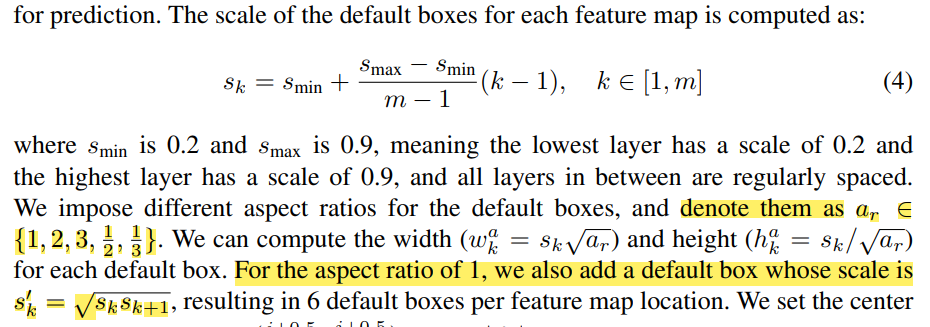

### 3. Loss 함수 변경 (20%)
현재 Localization loss는 L2 loss가 사용되고 있다. 이를 Smooth L1 Loss(Huber Loss)로 바꾸어 적용하여라.
- Smooth L1 Loss는 아래와 같다. (delta=1을 적용)
    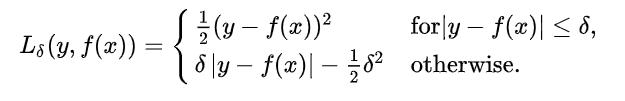
- Huber Loss는 직접 구현 하여라 (tf.keras.losses.Huber 와 같이 외부 라이브러리 사용시 0점)

### 4. Data Augmentation (10%)
- 이미지에 Random horizontal flip을 적용하여라.
- **중요** Canvas 전체를 flip하지 말고, CIFAR10 이미지를 flip한 후, canvas에 랜덤하게 배치한다.

### 5. mAP 성능 (10%)
- IoU=0.5:0.95기준 0.3 이상 달성하여라

## <과제 유의사항>
조교가 트레이닝을 수행해본 결과 트레이닝 중에 mAP의 등락이 있는 것이 발견되었다. Data의 특성에 의한 것으로 판단되니, 이러한 현상이 발견되더라도 당황하지 말고 트레이닝을 진행해도 된다.

In [12]:
import os
from pathlib import Path
import math
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn import model_selection
import tensorflow as tf
from tensorflow import keras
from keras import layers, regularizers
from keras.models import Model
from keras.datasets import cifar10
from keras import backend
from keras.applications import imagenet_utils
from utils import calc_iou, match_bipartite_greedy, match_multi, convert_coord, decode_detections

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_visible_devices(gpu, 'GPU')
    tf.config.experimental.set_memory_growth(gpu, True)

import matplotlib.patches as patches
from collections import defaultdict

In [2]:
IMG_SIZE = 224
n_classes = 10
pos_iou_threshold = 0.3
neg_iou_threshold = 0.3
score_threshold = 0.01
layer_width=[28, 14, 7, 4, 2, 1]
num_boxes = [3, 5, 5, 5, 3, 3]
aspect_ratio = [1, 2, 1/2, 3, 1/3]
s_max = 0.90
s_min = 0.50
batch_size = 32
log_dir = './'
model_name = 'mobilenetSSD'
model_csv_path = Path(log_dir).resolve() / (model_name + '.csv') # os.path.join(log_dir, (model_name + '.csv'))

### Preprocessing

In [26]:
#Load data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train, y_train, test_size=0.1)
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

train_size = x_train.shape[0]
valid_size = x_valid.shape[0]
test_size = x_test.shape[0]

print(train_size, valid_size, test_size)

45000 5000 10000


In [4]:
class SSDInputEncodingGenerator(keras.utils.Sequence):
    def __init__(
            self, 
            img_height, 
            img_width, 
            layer_width, 
            n_classes, 
            num_boxes, 
            s_max, 
            s_min, 
            aspect_ratio, 
            pos_iou_threshold,
            neg_iou_threshold,
            background_id,
            images,
            labels, 
            data_size,
            batch_size=32
        ):
        #Consider Background class
        self.img_height = img_height
        self.img_width = img_width
        self.n_class_withbg = n_classes + 1  #Add background class
        self.num_boxes = num_boxes  #List of number of boxes in each classifier layer
        self.s_max = s_max # Largest scale of default box
        self.s_min = s_min # Smallest scale of default box
        self.aspect_ratio = aspect_ratio # List of aspect ratios
        self.layer_width = layer_width
        self.pos_iou_threshold = pos_iou_threshold
        self.neg_iou_threshold = neg_iou_threshold
        self.background_id = background_id
        self.batch_size=batch_size
        self.images = images
        self.labels = labels
        self.shuffle = False
        self.data_size = data_size
        
        self.xmin_random = np.random.randint(self.img_height - 64, size=[self.data_size])
        self.ymin_random = np.random.randint(self.img_height - 64, size=[self.data_size])
        
        self.on_epoch_end()
        
    def convert_image(self, image, label, indexes):
        """
        Convert classification data to object detection data
        Randomly locate image in the middle of black canvas    
        Input
            x: Image, shape: (batch_size, image size, image size, #channels)
            y: label, shape: (batch_size, )
        output
            out_x: Image located in the random location of black canvas, shape: (batch_size, canvas size, canvas size, 3)
            out_y: label and location of corners(xmin,ymin,xmax,ymax), shape: (batch_size, #objects per image, 1+4) # Objects per image = 1

        """
        orig_image_size = 64
        channels = image.shape[-1]

        # prepare black canvas: 224, 224, 3
        canvas = np.zeros((self.batch_size, self.img_height, self.img_width, channels), dtype=np.int32)
        out_y = np.zeros((self.batch_size, 1, 5))

        xmin = self.xmin_random[indexes]  # coor of x
        ymin = self.ymin_random[indexes]  # coor of y
        xmax = xmin + orig_image_size  
        ymax = ymin + orig_image_size  

        resized = np.zeros((orig_image_size, orig_image_size, 3))
        for i in range(self.batch_size):
            random_flipped_image = tf.image.random_flip_left_right(image[i]).numpy()
            resized = cv2.resize(random_flipped_image, dsize=(orig_image_size, orig_image_size))
            canvas[i, xmin[i]:xmax[i], ymin[i]:ymax[i], :] = resized

        out_y[:, 0, 0] = label[:, 0]
        out_y[:, 0, -4:] = np.column_stack([xmin, ymin, xmax, ymax])

        return canvas, out_y
        
    def __getitem__(self, index):
        '''
        Generate one batch of data
        '''
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y
    
    def on_epoch_end(self):
        '''
        Updates indexes after each epoch
        '''
        self.indexes = np.arange(self.data_size)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.images.shape[0] / self.batch_size))
        
    def __data_generation(self, indexes):
        """
        Input: ground truth label,shape: (batch_size, #object per image, 1 + 4)
        Output: y_encoded, shape: (batch_size, sum of grid size of all classifier * num_boxes, n_class_withbg + 4 + 4)
        1. Create y_encoded template: (B, num_boxes, class + 4 + 4) 4 for gt coordinates and 4 for anchor boxes
        2. For each ground truth, calculate iou of gt and anchor boxes
        3. Find the highest matching anchor box per each gt and fill in y_encoded template
        4. Multi object matching
        5. Apply negative iou threshold
        6. Transform into Delta format
        """
        # images: (B, 244, 244, 3), gt_label: (B, 1, 5)
        images, gt_label = self.convert_image(self.images[indexes], self.labels[indexes], indexes)        
        
        # Make class vector to one hot format
        class_vector = np.eye(self.n_class_withbg)        
        
        #  layer_width = [28, 14, 7, 4, 2, 1]
        #        s_max = 0.9  
        #        s_min = 0.5
        #            s = [0.9, 0.82, 0.74, 0.66, 0.58, 0.5]
        #            l = [ 28,   14,    7,    4,    2,   1]
        #    num_boxes = [  3,    5,    5,    5,    3,   3]
        # aspect_ratio = [ 1, 1/2, 2, 3, 1/3]
        n_layers = len(self.layer_width)
        ss = []
        for iw in range(n_layers):
            # lowest layer has `s_min` scale, highest layer has `s_max` scale
            # 0: highest layer = first detection layer / 5: lowest layer = last detection layer
            s = self.s_min + (self.s_max - self.s_min) / (n_layers - 1) * (n_layers - iw - 1)
            ss.append(s)

        for iw in range(n_layers):
            l = self.layer_width[iw]            
            num_box = self.num_boxes[iw]
            # box_tensor
            # row(l*l*num_box): box1(i=0, j=0), box2(i=0, j=0), box3(i=0, j=0), box1(i=0, j=1), box2(i=0, j=1), box3(i=0, j=1) ...
            # col(4): (cx, cy, w, h)
            # before normalize e.g., iw=0, s=0.6, l=14, box_id = 0
            # cx = [0.5, 0.5, 0.5, 0.5]
            # cy = [0.5, 1.5, 2.5, 3.5]
            box_tensor = np.zeros((l * l * num_box, 4))   
            for i in range(l):
                for j in range(l):
                    for box_idx in range(num_box):
                        aspect = self.aspect_ratio[box_idx]
                        if aspect == 1 and (iw != (n_layers-1)):
                            s = math.sqrt(ss[iw] * ss[iw+1])
                        else:
                            s = ss[iw]
                        box_tensor[(i * l + j) * num_box + box_idx, 0] = (0.5 + i) / l
                        box_tensor[(i * l + j) * num_box + box_idx, 1] = (0.5 + j) / l
                        box_tensor[(i * l + j) * num_box + box_idx, 2] = s * math.sqrt(aspect) / l
                        box_tensor[(i * l + j) * num_box + box_idx, 3] = s / math.sqrt(aspect) / l
            box_tensor = convert_coord(box_tensor, type='centroid2corner')
            
            if iw == 0:
                boxes_tensor = box_tensor                
            else:                    
                boxes_tensor = np.concatenate((boxes_tensor, box_tensor), axis = 0)  # (l*l*num_box*len(layer_width), 4)
            
            class_tensor = np.zeros((l * l * num_box , self.n_class_withbg))
            
            if iw == 0:
                classes_tensor = class_tensor                
            else:                    
                classes_tensor = np.concatenate((classes_tensor, class_tensor), axis = 0)
        
        box_class_tensor = np.concatenate((classes_tensor, boxes_tensor, boxes_tensor), axis = 1)
        y_encoded = np.tile(box_class_tensor, (self.batch_size, 1, 1))
        # class: 11 + gt: 4 + diff with gt: 4
        y_encoded[:, :, self.background_id] = 1 # All boxes are background boxes by default.
        
        # Ground truth matching
        # images: (B, 244, 244, 3), gt_label: (B, 1, 5)
        for i in range(self.batch_size):
            gt_one_label = gt_label[i]
            m = gt_one_label.shape[0]
            if gt_one_label.shape[0] == 0: continue # If there is no object, skip
            
            # Normalize ground truth
            gt_one_label[:,[-4,-2]] /= self.img_width
            gt_one_label[:,[-3,-1]] /= self.img_height
            
            # Find the iou of ground truth and all anchor boxes
            similarities = calc_iou(gt_one_label[:, -4:], y_encoded[i, :, -4:])            
            
            # Find the highest matching anchor box per each ground truth boxes
            matches = match_bipartite_greedy(similarities)
            
            # Convert ground truth class label to one hot encoding            
            gt_class = np.array(gt_one_label[:,0] + 1, dtype=np.int32)
                        
            # Fill in y_encoded
            y_encoded[i, matches, :self.n_class_withbg] = class_vector[gt_class]
            y_encoded[i, matches, -8:-4] = gt_one_label[:, 1:]
            
            # Set the matched anchor boxes to 0 to indicate they are matched before multi object matching
            similarities[:,matches] = 0
            
            # Multi object matching
            # Similar process to bipartite matching
            matches_anchor, matches_gt = match_multi(similarities, threshold=self.pos_iou_threshold)            
            
            if len(matches_gt) > 0:            

                y_encoded[i, matches_anchor, :self.n_class_withbg] = class_vector[gt_class[matches_gt]]           
                y_encoded[i, matches_anchor, -8:-4] = gt_one_label[matches_gt,1:]

                # Set the matched anchor boxes to 0 to indicate they are matched before applying negative iou threshold
                similarities[:,matches_anchor] = 0
            
            # All background boxes whose iou are greater than neg_iou_threshold 
            # are set to neutral(neither background nor class)
            max_bg_similarities = np.amax(similarities, axis = 0)
            neutral_boxes = np.nonzero(max_bg_similarities >= self.neg_iou_threshold)[0]
            y_encoded[i, neutral_boxes, self.background_id] = 0
        
        #Convert coordinate from corner 2 centroid
        y_encoded[:,:,:-4] = convert_coord(y_encoded[:,:,:-4], type='corner2centroid')
        y_encoded = convert_coord(y_encoded, type='corner2centroid')        
        y_encoded[:,:,[-8, -7]] -= y_encoded[:,:,[-4, -3]] # (cx(gt) - cx(d_box)) # (cy(gt) - cy(d_box))
        y_encoded[:,:,[-8, -7]] /= y_encoded[:,:,[-2, -1]] # (cx(gt) - cx(d_box)) / w(d_box) # (cy(gt) - cy(d_box)) / h(d_box)
        y_encoded[:,:,[-6, -5]] = np.log(y_encoded[:,:,[-6, -5]] / y_encoded[:,:,[-2, -1]]) #log(w(gt) / w(d_box)) #log(h(gt) / h(d_box))
                  
        return images, y_encoded

In [5]:
ssd_input_gen = SSDInputEncodingGenerator(
    img_height=IMG_SIZE, 
    img_width=IMG_SIZE, 
    layer_width=layer_width, 
    n_classes=n_classes, 
    num_boxes=num_boxes, 
    s_max=s_max, 
    s_min=s_min, 
    aspect_ratio=aspect_ratio, 
    pos_iou_threshold=pos_iou_threshold,
    neg_iou_threshold=neg_iou_threshold,
    background_id=0,
    images=x_train,
    labels=y_train,
    data_size=train_size,
    batch_size=batch_size
)

ssd_valid_gen = SSDInputEncodingGenerator(
    img_height=IMG_SIZE, 
    img_width=IMG_SIZE, 
    layer_width=layer_width, 
    n_classes=n_classes, 
    num_boxes=num_boxes, 
    s_max=s_max, 
    s_min=s_min, 
    aspect_ratio=aspect_ratio, 
    pos_iou_threshold=pos_iou_threshold,
    neg_iou_threshold=neg_iou_threshold,
    background_id=0,
    images=x_valid,
    labels=y_valid,
    data_size=valid_size,
    batch_size=batch_size
)

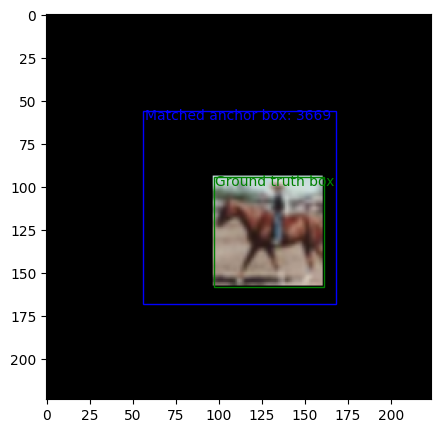

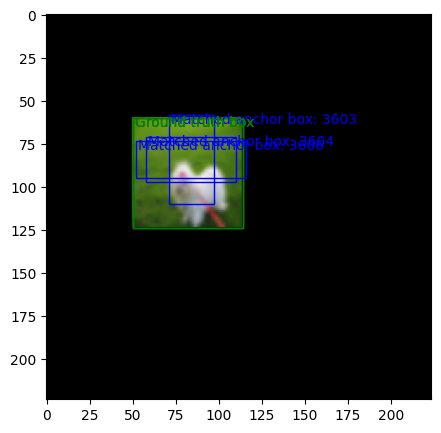

In [6]:
import matplotlib.patches as patches

def show(image, label, img_width, img_height):
    
    fig, ax = plt.subplots(1, figsize=(5, 5))
    ax.imshow(image)
    gt_boxes = np.argwhere(label[:,0]==0)

    for match in gt_boxes:
        anchor_box = label[match[0],-4:]
        gt_box = label[match[0],-8:-4]
        xmin = anchor_box[0] - anchor_box[2]/2
        ymin = anchor_box[1] - anchor_box[3]/2
        w = anchor_box[2]
        h = anchor_box[3]        
        
        w_gt = math.exp(gt_box[2]) * anchor_box[2] * img_width
        h_gt = math.exp(gt_box[3]) * anchor_box[3] * img_width
        cx_gt = (gt_box[0] * anchor_box[2] + anchor_box[0]) * img_width
        cy_gt = (gt_box[1] * anchor_box[3] + anchor_box[1]) * img_width
        xmin_gt = (cx_gt - w_gt/2) 
        ymin_gt = (cy_gt - h_gt/2) 
        
        rect = patches.Rectangle((ymin_gt, xmin_gt), h_gt, w_gt, linewidth=1, edgecolor='g', facecolor='none')
        ax.text(ymin_gt+1, xmin_gt+5, 'Ground truth box', color='g')
        ax.add_patch(rect)
        
        xmin *= img_width
        ymin *= img_height
        w *= img_width
        h *= img_height        
        
        rect = patches.Rectangle((ymin,xmin),h,w,linewidth=1,edgecolor='b',facecolor='none')
        ax.text(ymin+1, xmin+5, 'Matched anchor box: {}'.format(match[0]), color='b')
        ax.add_patch(rect)
    plt.show()
    

image, label = next(iter(ssd_input_gen))
for i in range(2):
    show(image[i], label[i], IMG_SIZE, IMG_SIZE)

In [7]:
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor) # 더 가까운 divisor의 배수로 올림 4,5,6,7,8,9,10,11 -> 8, 12~19 -> 16 ...
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id):
    #Get the channel axis and the input channel size
    channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1
    in_channels = backend.int_shape(inputs)[channel_axis]
    
    pointwise_conv_filters = int(alpha * filters)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8) # Make sure the output filter size is the multiple of 8
    
    #Set the prefix
    prefix = 'block_{}_'.format(block_id)
    
    x = inputs
    
    #Expansion block    
    if block_id: # No expansion for block 0
        x = layers.Conv2D(filters = expansion * in_channels, kernel_size = 1, strides = 1, padding='same',
                          use_bias=False, activation=None, kernel_regularizer=regularizers.l2(0.00004),
                          name=prefix + 'expand')(x)
        x = layers.BatchNormalization(axis=channel_axis, momentum=0.999, epsilon=0.001, 
                                      name=prefix + 'expand_BN')(x)
        x = layers.ReLU(6, name=prefix + 'expand_relu')(x)
    else: 
        prefix = 'expanded_conv_'
    
    
    # Depthwise convolution
    #if stride == 2:
        #Adjust zero paddings for strides, when input hieght and width are odd add (1,1,1,1) padding / when even, add (0,1,0,1)
        #x = layers.ZeroPadding2D(padding=correct_pad(x, 3),
        #                         name=prefix + 'pad')(x)
    
    x = layers.DepthwiseConv2D(kernel_size = 3, strides = stride, 
                               #padding='same' if stride == 1 else 'valid',
                               padding='same',
                               use_bias=False, activation=None, kernel_regularizer=regularizers.l2(0.00004),
                               name=prefix + 'depthwise')(x)
    x = layers.BatchNormalization(axis=channel_axis, momentum=0.999, epsilon=0.001,
                                 name=prefix + 'depthwise_BN')(x)
    x = layers.ReLU(6, name=prefix + 'relu')(x)
    
    #Pointwise convolution(Bottleneck)
    x = layers.Conv2D(filters = pointwise_filters, kernel_size = 1, strides = 1, padding='same',
                      use_bias=False, activation=None, kernel_regularizer=regularizers.l2(0.00004),
                      name=prefix + 'project')(x)
    x = layers.BatchNormalization(axis=channel_axis, momentum=0.999, epsilon=0.001,
                                 name=prefix + 'project_BN')(x)
    
    #Inverted residual only when valid(Input size = output_size)
    if in_channels == pointwise_filters and stride == 1:
        return layers.add([inputs, x])
    return x

In [8]:
from keras.layers import Layer, InputSpec

class AnchorBoxes(Layer):    
    def __init__(self, layer_width, n_class_withbg, num_boxes,
                 s_max, s_min, aspect_ratio, index, **kwargs):             
        self.layer_width = layer_width
        self.n_class_withbg = n_class_withbg
        self.num_boxes = num_boxes
        self.s_max = s_max
        self.s_min = s_min
        self.aspect_ratio = aspect_ratio
        self.index = index

        n_layers = len(self.layer_width)
        self.ss = []
        for iw in range(n_layers):
            s = self.s_min + (self.s_max - self.s_min) / (n_layers - 1) * (n_layers - iw - 1)
            self.ss.append(s)
        super(AnchorBoxes, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        super(AnchorBoxes, self).build(input_shape)
    
    def compute_output_shape(self, input_shape):
        if keras.backend.image_data_format() == 'channels_last':
            batch_size, feature_map_height, feature_map_width, feature_map_channels = input_shape
       
        return (batch_size, feature_map_height*feature_map_width*self.n_boxes, 4)
    
    def get_config(self):
        config = {
            'layer_width': list(self.layer_width),                        
            'n_class_withbg': self.n_class_withbg,
            'num_boxes': self.num_boxes,
            's_max': self.s_max,
            's_min': self.s_min,
            'aspect_ratio': list(self.aspect_ratio)            
        }
        base_config = super(AnchorBoxes, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, x, mask=None):
        
        # s = self.s_min + (self.s_max - self.s_min) / (n_layers - 1) * (len(self.layer_width) - self.index - 1)
        l = self.layer_width[self.index]
        num_box = self.num_boxes[self.index]            
        box_tensor = np.zeros((l * l * num_box, 4))

        for i in range(self.layer_width[self.index]):                    
            for j in range(self.layer_width[self.index]):
                for box_idx in range(num_box):
                    aspect = self.aspect_ratio[box_idx]
                    if aspect == 1 and (self.index != (len(self.layer_width)-1)):
                        s = math.sqrt(self.ss[self.index] * self.ss[self.index+1])
                    else:
                        s = self.ss[self.index]
                    box_tensor[(i * l + j) * num_box + box_idx, 0] = (0.5 + i) / l
                    box_tensor[(i * l + j) * num_box + box_idx, 1] = (0.5 + j) / l
                    box_tensor[(i * l + j) * num_box + box_idx, 2] = s * math.sqrt(aspect) / l
                    box_tensor[(i * l + j) * num_box + box_idx, 3] = s / math.sqrt(aspect) / l

        box_tensor = np.expand_dims(box_tensor, axis = 0)
        return tf.tile(tf.constant(box_tensor, dtype=tf.float32), (tf.shape(x)[0],1,1))

In [9]:
def pretrained_MobileNetV2SSD():
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
    n_classes=10
    layer_width=[14,7,4,2,1]
    num_boxes=[3,3,3,3,3]
    alpha=1.0

    n_class_withbg = n_classes + 1 # Add background class
    
    inputs = layers.Input(shape=input_shape)
    
    first_block_filters = _make_divisible(32 * alpha, 8)
    # first conv layer: 224x224x3 -> 112x112x32
    x = layers.Conv2D(first_block_filters, kernel_size=3, strides=(2, 2), padding='same',  use_bias=False, 
                      bias_initializer='zeros',  kernel_regularizer=regularizers.l2(0.00004),
                      name='Conv1')(inputs)
    
    x = layers.BatchNormalization(
      axis=-1, epsilon=1e-3, momentum=0.999, name='bn_Conv1')(x)
    
    x = layers.ReLU(6., name='Conv1_relu')(x)
    
    
    # inverted residual blocks
    # 1st bottleneck block: 112x112x32 -> 112x112x16
    x = _inverted_res_block(
      x, filters=16, alpha=alpha, stride=1, expansion=1, block_id=0)

    # 2nd bottleneck block: 112x112x16 -> 56x56x24
    x = _inverted_res_block(
      x, filters=24, alpha=alpha, stride=2, expansion=6, block_id=1)
    x = _inverted_res_block(
      x, filters=24, alpha=alpha, stride=1, expansion=6, block_id=2)

    # 3rd bottleneck block: 56x56x24 -> 28x28x32
    x = _inverted_res_block(
      x, filters=32, alpha=alpha, stride=2, expansion=6, block_id=3)
    x = _inverted_res_block(
      x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=4)
    x = _inverted_res_block(
      x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=5)

    # 4th bottleneck block: 28x28x32 -> 14x14x64
    x = _inverted_res_block(
      x, filters=64, alpha=alpha, stride=2, expansion=6, block_id=6)
    x = _inverted_res_block(
      x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=7)
    x = _inverted_res_block(
      x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=8)
    x = _inverted_res_block(
      x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=9)
        
    classifier_1_conf = layers.Conv2D(num_boxes[0] * n_class_withbg, kernel_size = 3, padding='same', use_bias=False, name='classifier_1_conf')(x)
    classifier_1_loc = layers.Conv2D(num_boxes[0] * 4, kernel_size = 3, padding='same', use_bias=False, name='classifier_1_loc')(x)
    

    x = layers.Conv2D(256, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(512, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) #7x7
    
    classifier_2_conf = layers.Conv2D(num_boxes[1] * n_class_withbg, kernel_size = 3, padding='same', use_bias=False, name='classifier_2_conf')(x)
    classifier_2_loc = layers.Conv2D(num_boxes[1] * 4, kernel_size = 3, padding='same', use_bias=False, name='classifier_2_loc')(x)
        
    x = layers.Conv2D(128, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) # 4x4
    
    classifier_3_conf = layers.Conv2D(num_boxes[2] * n_class_withbg, kernel_size = 3, padding='same', use_bias=False, name='classifier_3_conf')(x)
    classifier_3_loc = layers.Conv2D(num_boxes[2] * 4, kernel_size = 3, padding='same', use_bias=False, name='classifier_3_loc')(x)    
        
    x = layers.Conv2D(128, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) # 2x2
    
    classifier_4_conf = layers.Conv2D(num_boxes[3] * n_class_withbg, kernel_size = 3, padding='same', use_bias=False, name='classifier_4_conf')(x)
    classifier_4_loc = layers.Conv2D(num_boxes[3] * 4, kernel_size = 3, padding='same', use_bias=False, name='classifier_4_loc')(x)   
    
    x = layers.Conv2D(128, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) # 1x1
    
    classifier_5_conf = layers.Conv2D(num_boxes[4] * n_class_withbg, kernel_size = 3, padding='same', use_bias=False, name='classifier_5_conf')(x)
    classifier_5_loc = layers.Conv2D(num_boxes[4] * 4, kernel_size = 3, padding='same', use_bias=False, name='classifier_5_loc')(x)

    
    ### 아래 실습하면서 완성
    #Classification tensors    
    classifier_1_conf = layers.Reshape((layer_width[0] * layer_width[0] * num_boxes[0], n_class_withbg))(classifier_1_conf)
    classifier_2_conf = layers.Reshape((layer_width[1] * layer_width[1] * num_boxes[1], n_class_withbg))(classifier_2_conf)
    classifier_3_conf = layers.Reshape((layer_width[2] * layer_width[2] * num_boxes[2], n_class_withbg))(classifier_3_conf)
    classifier_4_conf = layers.Reshape((layer_width[3] * layer_width[3] * num_boxes[3], n_class_withbg))(classifier_4_conf)
    classifier_5_conf = layers.Reshape((layer_width[4] * layer_width[4] * num_boxes[4], n_class_withbg))(classifier_5_conf)   
    
    conf_layers = layers.concatenate([classifier_1_conf, classifier_2_conf, classifier_3_conf, classifier_4_conf, classifier_5_conf], axis = 1)
    
    
    #Apply softmax
    conf_layers_softmax = layers.Activation('softmax')(conf_layers)    
    
    #Localization tensors
    classifier_1_loc = layers.Reshape((layer_width[0] * layer_width[0] * num_boxes[0], 4))(classifier_1_loc)
    classifier_2_loc = layers.Reshape((layer_width[1] * layer_width[1] * num_boxes[1], 4))(classifier_2_loc)
    classifier_3_loc = layers.Reshape((layer_width[2] * layer_width[2] * num_boxes[2], 4))(classifier_3_loc)
    classifier_4_loc = layers.Reshape((layer_width[3] * layer_width[3] * num_boxes[3], 4))(classifier_4_loc)
    classifier_5_loc = layers.Reshape((layer_width[4] * layer_width[4] * num_boxes[4], 4))(classifier_5_loc)    
    
    loc_layers = layers.concatenate([classifier_1_loc, classifier_2_loc, classifier_3_loc, classifier_4_loc, classifier_5_loc], axis = 1)
    
    #Default anchor box tensors, They are constant and NOT trained !!
    #def __init__(self, layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index, **kwargs):     
    dbox_1 = AnchorBoxes(layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index = 0)(classifier_1_loc)
    dbox_2 = AnchorBoxes(layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index = 1)(classifier_2_loc)
    dbox_3 = AnchorBoxes(layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index = 2)(classifier_3_loc)
    dbox_4 = AnchorBoxes(layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index = 3)(classifier_4_loc)
    dbox_5 = AnchorBoxes(layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index = 4)(classifier_5_loc)
    
    dbox_layers = layers.concatenate([dbox_1, dbox_2, dbox_3, dbox_4, dbox_5], axis = 1)   
    
    #Concatenate Classification tensor, Localization tensor and Default anchor box tensor.
    detections = layers.concatenate([conf_layers_softmax, loc_layers, dbox_layers], axis=-1)

    outputs = detections
    
    return Model(inputs=inputs, outputs=outputs)
    

In [10]:
pretrained_model = pretrained_MobileNetV2SSD()
pretrained_model.load_weights('./training_checkpoints_SSD/ckpt_1', by_name=False)
weight_paths = pretrained_model.get_weight_paths()

In [13]:
def MobileNetV2SSD(
        input_shape,
        n_classes,
        layer_width,
        num_boxes,
        alpha=1.0
    ):
    
    n_class_withbg = n_classes + 1 # Add background class
    
    inputs = layers.Input(shape=input_shape)
    
    first_block_filters = _make_divisible(32 * alpha, 8)
    # first conv layer: 224x224x3 -> 112x112x32
    x = layers.Conv2D(
        first_block_filters, kernel_size=3, strides=(2, 2), padding='same', use_bias=False, 
        bias_initializer='zeros',  kernel_regularizer=regularizers.l2(0.00004),
        name='Conv1'
    )(inputs)
    
    x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name='bn_Conv1')(x)
    x = layers.ReLU(6., name='Conv1_relu')(x)
    
    # inverted residual blocks
    # 1st bottleneck block: 112x112x32 -> 112x112x16
    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1, expansion=1, block_id=0)

    # 2nd bottleneck block: 112x112x16 -> 56x56x24
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2, expansion=6, block_id=1)
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1, expansion=6, block_id=2)

    # 3rd bottleneck block: 56x56x24 -> 28x28x32
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2, expansion=6, block_id=3)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=4)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=5)

    # x: (28, 28, 32)
    classifier_0_conf = layers.Conv2D(num_boxes[0] * n_class_withbg, kernel_size=3, padding='same', use_bias=False, name='classifier_0_conf')(x)
    classifier_0_loc = layers.Conv2D(num_boxes[0] * 4, kernel_size=3, padding='same', use_bias=False, name='classifier_0_loc')(x)
    
    # 4th bottleneck block: 28x28x32 -> 14x14x64
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2, expansion=6, block_id=6)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=7)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=8)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=9)
    
    # layer_widths = [28, 14, 7, 4, 2, 1]
    # num_boxes = [3, 5, 5, 5, 3, 3]
    
    # x: (14, 14, 64)
    # classifier_1_conf = (14, 14, 64) -> (14, 14, 5*11)
    # classifier_1_loc = (14, 14, 64) -> (14, 14, 5*4)
    classifier_1_conf = layers.Conv2D(num_boxes[1] * n_class_withbg, kernel_size=3, padding='same', use_bias=False, name='classifier_1_conf')(x)
    classifier_1_loc = layers.Conv2D(num_boxes[1] * 4, kernel_size=3, padding='same', use_bias=False, name='classifier_1_loc')(x)
    # x: (14, 14, 64) -> (7, 7, 512)
    x = layers.Conv2D(256, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(512, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) #7x7
    
    # x: (7, 7, 512)
    # classifier_2_conf = (7, 7, 512) -> (7, 7, 5*11)
    # classifier_2_loc = (7, 7, 512) -> (7, 7, 5*4)
    classifier_2_conf = layers.Conv2D(num_boxes[2] * n_class_withbg, kernel_size=3, padding='same', use_bias=False, name='classifier_2_conf')(x)
    classifier_2_loc = layers.Conv2D(num_boxes[2] * 4, kernel_size=3, padding='same', use_bias=False, name='classifier_2_loc')(x)
    # x: (7, 7, 512) -> (4, 4, 256)
    x = layers.Conv2D(128, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) # 4x4
    
    # x: (4, 4, 256)
    # classifier_3_conf = (4, 4, 256) -> (4, 4, 5*11)
    # classifier_3_loc = (4, 4, 256) -> (4, 4, 5*4)
    classifier_3_conf = layers.Conv2D(num_boxes[3] * n_class_withbg, kernel_size=3, padding='same', use_bias=False, name='classifier_3_conf')(x)
    classifier_3_loc = layers.Conv2D(num_boxes[3] * 4, kernel_size=3, padding='same', use_bias=False, name='classifier_3_loc')(x)    
    # x: (4, 4, 256) -> (2, 2, 256)
    x = layers.Conv2D(128, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) # 2x2

    # x: (2, 2, 256)
    # classifier_4_conf = (2, 2, 256) -> (2, 2, 3*11)
    # classifier_4_loc = (2, 2, 256) -> (2, 2, 3*4)
    classifier_4_conf = layers.Conv2D(num_boxes[4] * n_class_withbg, kernel_size=3, padding='same', use_bias=False, name='classifier_4_conf')(x)
    classifier_4_loc = layers.Conv2D(num_boxes[4] * 4, kernel_size=3, padding='same', use_bias=False, name='classifier_4_loc')(x)    
    # x: (2, 2, 256) -> (1, 1, 256)
    x = layers.Conv2D(128, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) # 2x2
    
    # x: (1, 1, 256)
    # classifier_5_conf = (1, 1, 256) -> (1, 1, 3*11)
    # classifier_5_loc = (1, 1, 256) -> (1, 1, 3*4)
    classifier_5_conf = layers.Conv2D(num_boxes[5] * n_class_withbg, kernel_size=3, padding='same', use_bias=False, name='classifier_5_conf')(x)
    classifier_5_loc = layers.Conv2D(num_boxes[5] * 4, kernel_size=3, padding='same', use_bias=False, name='classifier_5_loc')(x)   

    # Classification tensors 
    # classifier_1_conf: (14, 14, 3*11) -> (14*14*3, 11)
    classifier_0_conf = layers.Reshape((layer_width[0] * layer_width[0] * num_boxes[0], n_class_withbg))(classifier_0_conf)
    classifier_1_conf = layers.Reshape((layer_width[1] * layer_width[1] * num_boxes[1], n_class_withbg))(classifier_1_conf)
    classifier_2_conf = layers.Reshape((layer_width[2] * layer_width[2] * num_boxes[2], n_class_withbg))(classifier_2_conf)
    classifier_3_conf = layers.Reshape((layer_width[3] * layer_width[3] * num_boxes[3], n_class_withbg))(classifier_3_conf)
    classifier_4_conf = layers.Reshape((layer_width[4] * layer_width[4] * num_boxes[4], n_class_withbg))(classifier_4_conf)
    classifier_5_conf = layers.Reshape((layer_width[5] * layer_width[5] * num_boxes[5], n_class_withbg))(classifier_5_conf)  
    
    conf_layers = layers.concatenate(
        [classifier_0_conf, classifier_1_conf, classifier_2_conf, classifier_3_conf, classifier_4_conf, classifier_5_conf], 
        axis = 1
    )
    #Apply softmax
    conf_layers_softmax = layers.Activation('softmax')(conf_layers)    
    
    #Localization tensors
    classifier_0_loc = layers.Reshape((layer_width[0] * layer_width[0] * num_boxes[0], 4))(classifier_0_loc)
    classifier_1_loc = layers.Reshape((layer_width[1] * layer_width[1] * num_boxes[1], 4))(classifier_1_loc)
    classifier_2_loc = layers.Reshape((layer_width[2] * layer_width[2] * num_boxes[2], 4))(classifier_2_loc)
    classifier_3_loc = layers.Reshape((layer_width[3] * layer_width[3] * num_boxes[3], 4))(classifier_3_loc)
    classifier_4_loc = layers.Reshape((layer_width[4] * layer_width[4] * num_boxes[4], 4))(classifier_4_loc)
    classifier_5_loc = layers.Reshape((layer_width[5] * layer_width[5] * num_boxes[5], 4))(classifier_5_loc)   
    
    loc_layers = layers.concatenate(
        [classifier_0_loc, classifier_1_loc, classifier_2_loc, classifier_3_loc, classifier_4_loc, classifier_5_loc], 
        axis = 1
    )
    
    # Default anchor box tensors, They are constant and NOT trained !!
    #def __init__(self, layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index, **kwargs):     
    dbox_0 = AnchorBoxes(layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index = 0)(classifier_0_loc)
    dbox_1 = AnchorBoxes(layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index = 1)(classifier_1_loc)
    dbox_2 = AnchorBoxes(layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index = 2)(classifier_2_loc)
    dbox_3 = AnchorBoxes(layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index = 3)(classifier_3_loc)
    dbox_4 = AnchorBoxes(layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index = 4)(classifier_4_loc)
    dbox_5 = AnchorBoxes(layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index = 5)(classifier_5_loc)
    
    dbox_layers = layers.concatenate([dbox_0, dbox_1, dbox_2, dbox_3, dbox_4, dbox_5], axis = 1)
    
    #Concatenate Classification tensor, Localization tensor and Default anchor box tensor.
    detections = layers.concatenate([conf_layers_softmax, loc_layers, dbox_layers], axis=-1)
    outputs = detections
    return Model(inputs=inputs, outputs=outputs)
    

In [12]:
model = MobileNetV2SSD((IMG_SIZE, IMG_SIZE, 3), n_classes, layer_width, num_boxes, alpha=1.0)

In [13]:
to_restore_keys = defaultdict(list)
for k in list(weight_paths.keys()):
    if not ('classifier' in k or 'conv2d' in k):
        key, attribute = k.split('.')
        to_restore_keys[key].append(attribute)

In [14]:
# manual load pretrained weights, skip all classfier weight to be retrain
for l in model.layers:
    if l.name in to_restore_keys.keys():
        print(f'{l.name} weight restored')
        l.set_weights([weight_paths[f'{l.name}.{attr}'] for attr in to_restore_keys[l.name]])

Conv1 weight restored
bn_Conv1 weight restored
expanded_conv_depthwise weight restored
expanded_conv_depthwise_BN weight restored
expanded_conv_project weight restored
expanded_conv_project_BN weight restored
block_1_expand weight restored
block_1_expand_BN weight restored
block_1_depthwise weight restored
block_1_depthwise_BN weight restored
block_1_project weight restored
block_1_project_BN weight restored
block_2_expand weight restored
block_2_expand_BN weight restored
block_2_depthwise weight restored
block_2_depthwise_BN weight restored
block_2_project weight restored
block_2_project_BN weight restored
block_3_expand weight restored
block_3_expand_BN weight restored
block_3_depthwise weight restored
block_3_depthwise_BN weight restored
block_3_project weight restored
block_3_project_BN weight restored
block_4_expand weight restored
block_4_expand_BN weight restored
block_4_depthwise weight restored
block_4_depthwise_BN weight restored
block_4_project weight restored
block_4_projec

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

## Loss

In [14]:
class SSDLoss():
    def __init__(self, n_classes, background_id, neg_pos_ratio=3, n_neg_min=0, alpha=1.0, beta=1.0, delta=1.0):
        self.neg_pos_ratio = neg_pos_ratio
        self.n_neg_min = 0
        self.alpha = alpha
        self.beta = beta
        self.delta = delta # for smoothL1Loss
        self.background_id = background_id
        self.n_class_withbg = n_classes + 1
        
    def L2Loss(self, loc_true, loc_pred):
        """
        y_true: ground truth localization tensor, shape: (batch_size, num_boxes, 4)
        y_pred: predicted localization tensor, shape: (batch_size, num_boxes, 4)
        """
        diff = tf.abs(loc_pred - loc_true)        
        l2_loss = diff ** 2

        return tf.reduce_sum(l2_loss, axis=-1)
    
    def smoothL1Loss(self, loc_true, loc_pred):
        """
        y_true: ground truth localization tensor, shape: (batch_size, num_boxes, 4)
        y_pred: predicted localization tensor, shape: (batch_size, num_boxes, 4)
        """
        diff = loc_pred - loc_true
        huber_loss = tf.reduce_sum(
            tf.where(
                condition=tf.less_equal(tf.abs(diff), self.delta), 
                x = (1/2)*(diff**2),
                y = self.delta*(tf.abs(diff)) - (1/2)*self.delta**2
            ), axis=-1
        )
        return huber_loss
    
    def log_loss(self, class_true, class_pred):
        #classification loss
        class_pred = tf.maximum(class_pred, 1e-15)
        log_loss = -tf.reduce_sum(class_true * tf.math.log(class_pred), axis=-1)  # (batch_size, n_boxes)   
        return log_loss
        
    def compute_loss(self, y_true, y_pred):    
        """
        y_true: (batch_size, # boxes, n_class_withbg + 4)
        y_pred: (batch_size, # boxes, n_class_withbg + 4)
        """
        
        #Get the size of tensor
        batch_size = tf.shape(y_true)[0]
        n_boxes = tf.shape(y_pred)[1]
        
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
                
        classification_loss = self.log_loss(y_true[:, :, :self.n_class_withbg], y_pred[:, :, :self.n_class_withbg])
        positives = tf.reduce_max(y_true[:, :, 1:(self.n_class_withbg)], axis=-1) # Class is NOT background, (batch_size, n_boxes)       
        
        # Classification loss for positive boxes
        pos_class_loss = tf.reduce_sum(self.log_loss(y_true[:, :, 1:self.n_class_withbg], y_pred[:, :, 1:self.n_class_withbg]), axis=-1)
        
        negatives = y_true[:,:, self.background_id] # Class is background, (batch_size, n_boxes)
        n_positives = tf.reduce_sum(positives) # number of positive boxes, single number
        
        # Classification loss for negative boxes
        neg_class_loss_all = classification_loss * negatives #(batch_size, n_boxes)        
        n_neg_losses = tf.math.count_nonzero(neg_class_loss_all, dtype=tf.int32) # The number of nonzero entries in neg_class_loss_all
        
        # Keep the number of negative boxes between n_neg_min and neg_pos_ratio * positive_boxes        
        n_negative_keep = tf.minimum(tf.maximum(self.neg_pos_ratio * tf.cast(n_positives, dtype=tf.int32), self.n_neg_min), n_neg_losses)
        
        def f1():
            return tf.zeros([batch_size])
        
        # Get the "n_negative_keep" largest confidence negative boxes.
        def f2():
            #Resahpe neg_class_loss_all to 1d array
            neg_class_loss_all_1D = tf.reshape(neg_class_loss_all, [-1])

            # Find top 'n_negative_keep' boxes from neg_class_loss_all_1D
            values, indices = tf.nn.top_k(neg_class_loss_all_1D, k=n_negative_keep, sorted=False)

            #Then create a mask for negative boxes: For selected box above, set them as 1
            negatives_keep = tf.scatter_nd(indices=tf.expand_dims(indices, axis=1),
                                           updates=tf.ones_like(indices, dtype=tf.int32),
                                           shape=tf.shape(neg_class_loss_all_1D))
            negatives_keep = tf.cast(tf.reshape(negatives_keep, [batch_size, n_boxes]), dtype=tf.float32)            

            #Finally compute negative loss
            neg_class_loss = tf.reduce_sum(classification_loss * negatives_keep, axis=-1) #(batch_size)
            
            return neg_class_loss
        
        neg_class_loss = tf.cond(tf.equal(n_neg_losses, tf.constant(0)), f1, f2)           
        
        #Final classification loss: Sum of positive and negative loss
        class_loss = self.beta * pos_class_loss + neg_class_loss
        
        #localization loss
        loc_pred = y_pred[:,:,self.n_class_withbg:-4]
        loc_true = y_true[:,:,self.n_class_withbg:-4]
        # loc_loss = self.L2Loss(loc_true, loc_pred) # (batch_size, n_boxes) 
        loc_loss = self.smoothL1Loss(loc_true, loc_pred)      
        
        # Include only positive boxes in calculating localization loss
        loc_loss = tf.reduce_sum(positives * loc_loss, axis=-1) #(batch_size)     
        
        #Combine localization and classification loss, divide by matched default box(n_positives)
        total_loss = (class_loss + loc_loss * self.alpha) / tf.maximum(1.0, n_positives)
        
        # We divided by n_positives - # of all matched default boxes of "a batch"
        # Since keras divides by the size of batch, it is double division
        # To adjust this, we multiply by batch_size
        total_loss = total_loss * tf.cast(batch_size, dtype=tf.float32)
        
        return total_loss

In [17]:
ssd_loss = SSDLoss(n_classes = n_classes, background_id=0, neg_pos_ratio=1, alpha=10, beta=3)
optimzier = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=4e-5)
model.compile(loss=ssd_loss.compute_loss, optimizer=optimzier)

In [18]:
#decay could be applied using Learning rate scheduler
def decay(epoch):
    return 0.001 * (0.98 **(epoch - 1))

callbacks = []
checkpoint_dir = Path('./checkpoints').resolve()
model_cp_path = checkpoint_dir / "ckpt_{epoch}"
callbacks.append(tf.keras.callbacks.ModelCheckpoint(str(model_cp_path), monitor="val_loss", mode='min', save_weights_only=True))
callbacks.append(tf.keras.callbacks.LearningRateScheduler(decay))
callbacks.append(tf.keras.callbacks.CSVLogger(str(model_csv_path))) 

In [19]:
EPOCHES = 25
history = model.fit(
    ssd_input_gen,  
    validation_data=ssd_valid_gen,            
    epochs=EPOCHES,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/25
1406/1406 [==============================] - 503s 354ms/step - loss: 8.3246 - val_loss: 41.5625 - lr: 0.0010
Epoch 2/25
1406/1406 [==============================] - 365s 260ms/step - loss: 4.6635 - val_loss: 59.1831 - lr: 0.0010
Epoch 3/25
1406/1406 [==============================] - 270s 192ms/step - loss: 3.5535 - val_loss: 48.0181 - lr: 9.8000e-04
Epoch 4/25
1406/1406 [==============================] - 271s 193ms/step - loss: 3.0907 - val_loss: 60.7379 - lr: 9.6040e-04
Epoch 5/25
1406/1406 [==============================] - 273s 194ms/step - loss: 2.8254 - val_loss: 4.0408 - lr: 9.4119e-04
Epoch 6/25
1406/1406 [==============================] - 492s 350ms/step - loss: 2.6393 - val_loss: 65.2308 - lr: 9.2237e-04
Epoch 7/25
1406/1406 [==============================] - 644s 458ms/step - loss: 2.4976 - val_loss: 2.7953 - lr: 9.0392e-04
Epoch 8/25
1406/1406 [==============================] - 637s 453ms/step - loss: 2.3699 - val_loss: 71.9969 - lr: 8.8584e-04
Epoch 9/25
1406/14

In [15]:
import pandas as pd

df = pd.read_csv('./mobilenetSSD.csv')
best_model_idx = df.sort_values(by='val_loss')['epoch'].values[0]
best_model_idx

21

## Eval Functions

In [16]:
model = MobileNetV2SSD((IMG_SIZE, IMG_SIZE, 3), n_classes, layer_width, num_boxes, alpha=1.0)
model.load_weights(f'./checkpoints/ckpt_{best_model_idx}')

In [17]:
y_pred = model.predict(image)
# Decode the prediction for one image in the image batch
image_no = 0
y_decoded = decode_detections(
    np.expand_dims(y_pred[image_no], axis=0),
    n_classes=10, 
    confidence_thresh=0.01, 
    iou_threshold=0.45, 
    top_k = 10, 
    img_height = IMG_SIZE, 
    img_width = IMG_SIZE,
    background_id=0
)

1/1 [==============================] - 2s 2s/step


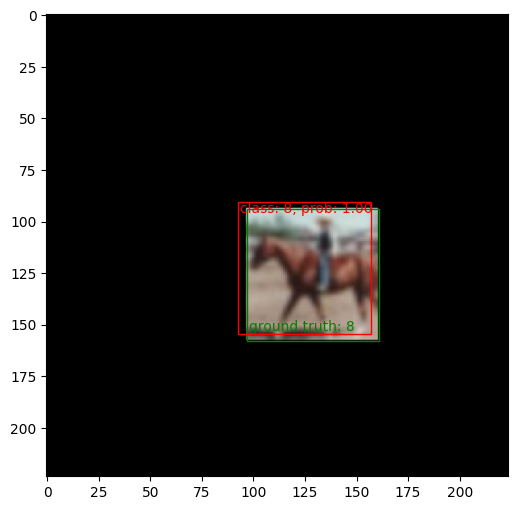

In [18]:
# Visualize the bounding box on the original image
import matplotlib.patches as patches

def show_prediction(image, label, prediction):
    
    fig,ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(image)
    gt_boxes = np.argwhere(label[:,0]==0)
    for match in gt_boxes:        
        anchor_box = label[match[0],-4:]
        gt_box = label[match[0], -8:-4]
        class_id = np.argwhere(label[match[0],:10]==1)        
                
        w = math.exp(gt_box[2]) * anchor_box[2]
        h = math.exp(gt_box[3]) * anchor_box[3]
        cx = gt_box[0] * anchor_box[2] + anchor_box[0]
        cy = gt_box[1] * anchor_box[3] + anchor_box[1]
        
        xmin = (cx - w/2) * IMG_SIZE
        ymin = (cy - h/2) * IMG_SIZE
        w = w * IMG_SIZE
        h = h * IMG_SIZE        
        
        rect = patches.Rectangle((ymin,xmin),h, w,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(rect)
        ax.text(ymin+1, xmin+w-5, 'ground truth: ' + str(class_id[0,0]), color='g')            
    
    pred_boxes= np.argwhere(prediction[:,1] > 0)    
        
    for pred in pred_boxes:
        box = prediction[pred[0],2:6]
        class_id = int(prediction[pred[0],0])   
        prob = prediction[pred[0],1]
        xmin = min(max(box[0],0),224)
        ymin = min(max(box[1],0),224)
        w = min(max(box[2],0),224) - xmin
        h = min(max(box[3],0),224) - ymin
        rect = patches.Rectangle((ymin,xmin),h, w,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)        
        ax.text(ymin+1, xmin+5, 'class: {}, prob: {:.2f}'.format(class_id, prob), color='r')
        
    plt.show()

show_prediction(image[image_no],label[image_no],y_decoded[0])

In [19]:
ssd_test_gen = SSDInputEncodingGenerator(
    IMG_SIZE, 
    IMG_SIZE, 
    layer_width=layer_width, 
    n_classes=n_classes, 
    num_boxes=num_boxes, 
    s_max=s_max, 
    s_min=s_min, 
    aspect_ratio=aspect_ratio, 
    pos_iou_threshold=pos_iou_threshold,
    neg_iou_threshold=neg_iou_threshold,
    background_id=0,
    images=x_test,
    labels=y_test,
    data_size=test_size,
    batch_size=batch_size
)

1/1 [==============================] - 0s 27ms/step


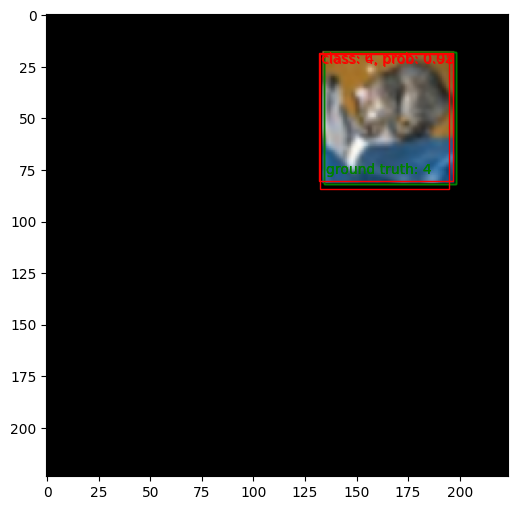

In [20]:
test_image, test_label = next(iter(ssd_test_gen))
test_pred = model.predict(test_image)
image_no = 0
test_decoded = decode_detections(
    np.expand_dims(test_pred[image_no], axis=0),
    n_classes=10, 
    confidence_thresh=0.01, 
    iou_threshold=0.45, 
    top_k=100, 
    img_height=IMG_SIZE, 
    img_width=IMG_SIZE,
    background_id=0
)
show_prediction(test_image[image_no], test_label[image_no], test_decoded[0])

In [21]:
# Function to dump prediction result in JSON format
import json
from tqdm import tqdm

def dump_coco_json(dataset_size, batch_size, generator, model, out_file):
    
    # Put the results in this list.
    results = []
    id_cnt = 0    
    
    for batch_X, batch_label in tqdm(generator, total=len(generator)):
        # Generate batch.
        #batch_X, batch_label = next(generator)
        # Predict.
        y_pred = model.predict(batch_X, verbose=False)

        # Decode.
        y_pred = decode_detections(y_pred,
                                   n_classes=10, 
                                   confidence_thresh=0.01,
                                   iou_threshold=0.45,
                                   top_k=200,                               
                                   img_height=IMG_SIZE, 
                                  img_width=IMG_SIZE,
                                  background_id=0)
        
        # Convert each predicted box into the results format.
        for k, batch_item in enumerate(y_pred):
            for box in batch_item:                
                cat_id = box[0]
                # Round the box coordinates to reduce the JSON file size.
                xmin = float(round(box[2], 1))
                ymin = float(round(box[3], 1))
                xmax = float(round(box[4], 1))
                ymax = float(round(box[5], 1))
                width = xmax - xmin
                height = ymax - ymin
                bbox = [xmin, ymin, width, height]
                result = {}
                result['image_id'] = id_cnt
                result['category_id'] = cat_id                
                result['score'] = float(round(box[1], 3))
                result['bbox'] = bbox
                results.append(result)                   
            id_cnt += 1
            if id_cnt == dataset_size:
                break 
            
    with open(out_file, 'w') as f:
        json.dump(results, f)

    print("Prediction results saved in '{}'".format(out_file))
    return

In [22]:
# Prediction to coco format
generator = ssd_test_gen
dataset_size = test_size
#dataset_size = 128
out_file='prediction_coco_format.json'
dump_coco_json(dataset_size, batch_size, generator, model, out_file)

100%|██████████| 312/312 [00:52<00:00,  5.89it/s]


Prediction results saved in 'prediction_coco_format.json'


In [23]:
#Get the coordinates of ground truth image from the generator
xmin_test = np.expand_dims(ssd_test_gen.xmin_random, axis=-1)
ymin_test = np.expand_dims(ssd_test_gen.ymin_random, axis=-1)
xmax_test = np.expand_dims(ssd_test_gen.xmin_random + 64, axis=-1)
ymax_test = np.expand_dims(ssd_test_gen.ymin_random + 64, axis=-1)

#Prepare ground truth boxes information(class_id, confidence(dummy), xmin, ymin, xmax, ymax)
gt_boxes = np.concatenate([y_test, np.ones([test_size, 1]), xmin_test, ymin_test, xmax_test, ymax_test], axis = -1)

In [24]:
# Store gt information in coco format
images = []
results = []
categories = []

for i in range(dataset_size):
    im = {}
    im['id'] = i
    im['width'] = IMG_SIZE
    im['height'] = IMG_SIZE
    im['file_name'] = 'image.jpg'
    images.append(im)
    
for i in range(n_classes):
    cat = {}
    cat['id'] = i
    cat['name'] = class_names[i]
    cat['supercategory'] = cat['name']
    categories.append(cat)
    
id_cnt = 0

for box in tqdm(gt_boxes, total=len(gt_boxes), desc='gt_boxes'):
    class_id = box[0]+1
    # Transform the consecutive class IDs back to the original COCO category IDs.
    #cat_id = classes_to_cats[class_id]
    cat_id = class_id
    # Round the box coordinates to reduce the JSON file size.
    xmin = float(round(box[2], 1))
    ymin = float(round(box[3], 1))
    xmax = float(round(box[4], 1))
    ymax = float(round(box[5], 1))
    width = xmax - xmin
    height = ymax - ymin
    bbox = [xmin, ymin, width, height]
    result = {}
    result['id'] = id_cnt
    result['image_id'] = id_cnt
    result['category_id'] = cat_id
    result['bbox'] = bbox
    result['iscrowd'] = 0
    result['area'] = width * height
    results.append(result)        
    id_cnt += 1
    
    if id_cnt == dataset_size:
        break

output_dict = {}
output_dict["images"] = images
output_dict["annotations"] = results
output_dict["categories"] = categories

out_file='gt_coco_format.json'

with open(out_file, 'w') as f:
    json.dump(output_dict, f)

gt_boxes: 100%|█████████▉| 9999/10000 [00:00<00:00, 98026.89it/s]


In [25]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

coco_gt = COCO('gt_coco_format.json')
coco_dt = coco_gt.loadRes('prediction_coco_format.json')
image_ids = sorted(coco_gt.getImgIds())
cocoEval = COCOeval(cocoGt=coco_gt,
                    cocoDt=coco_dt,
                    iouType='bbox')
cocoEval.params.imgIds  = image_ids
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.16s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.12s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.598
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.841
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.752
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.598
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.749
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.749
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe